In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import tarfile
import re
from collections import defaultdict


# Load the citation network
def load_citation_network(file_path):
    citations = []

    with open(file_path, "r") as file:
        for line in file:
            line = line.strip()
            # Skip empty lines and lines that start with '#'
            if line and not line.startswith('#'):
                citing, cited = map(int, line.split())
                citations.append({
                    'citing_paper': citing,
                    'cited_paper': cited
                })

    return pd.DataFrame(citations)

# Extract basic metadata (year, abstract) for temporal analysis
def extract_paper_metadata(abstracts_tar_path):
    metadata_records = []

    # Extract the tar file
    with tarfile.open(abstracts_tar_path, "r:gz") as tar:
        tar.extractall(path="/content/cit-HepTh-abstracts")

    base_path = Path("/content/cit-HepTh-abstracts")

    # Iterate through all files
    for year_folder in base_path.iterdir():
        if year_folder.is_dir():
            # Extract year from folder name
            year = int(year_folder.name) if year_folder.name.isdigit() else None

            for file in year_folder.glob("*.abs"):
                try:
                    with open(file, "r", encoding="utf-8", errors="ignore") as f:
                        content = f.read()

                    paper_id = int(file.stem)

                    # Extract abstract (usually after "Title:" and before "Authors:")
                    abstract_match = re.search(r'Title:\s*(.*?)\n.*?\n(.*?)(?=Authors:|$)',
                                             content, re.DOTALL)
                    title = abstract_match.group(1).strip() if abstract_match else ""
                    abstract = abstract_match.group(2).strip() if abstract_match else ""

                    metadata_records.append({
                        'paper_id': paper_id,
                        'year': year,
                        'title': title,
                        'abstract': abstract
                    })

                except Exception as e:
                    print(f"Error reading {file.name}: {e}")

    return pd.DataFrame(metadata_records)

# Create a comprehensive dataset
def create_citation_dataset(citation_file_path, abstracts_tar_path):
    """
    Create a comprehensive dataset combining citations and metadata
    """
    print("Loading citation network...")
    citations_df = load_citation_network(citation_file_path)
    print(f"Loaded {len(citations_df)} citations")

    print("Extracting paper metadata...")
    metadata_df = extract_paper_metadata(abstracts_tar_path)
    print(f"Loaded metadata for {len(metadata_df)} papers")

    # Get all unique paper IDs from both citing and cited papers
    all_paper_ids = set(citations_df['citing_paper'].unique()) | set(citations_df['cited_paper'].unique())

    # Create a complete papers dataframe
    papers_df = pd.DataFrame({'paper_id': list(all_paper_ids)})
    papers_df = papers_df.merge(metadata_df, on='paper_id', how='left')

    print(f"Dataset summary:")
    print(f"- Total papers: {len(papers_df)}")
    print(f"- Papers with metadata: {len(papers_df.dropna(subset=['year']))}")
    print(f"- Total citations: {len(citations_df)}")
    print(f"- Year range: {papers_df['year'].min():.0f} - {papers_df['year'].max():.0f}")

    return citations_df, papers_df


if __name__ == "__main__":
    # Load the data
    citation_file_path = "/content/Cit-HepTh.txt"
    abstracts_tar_path = "/content/cit-HepTh-abstracts.tar.gz"

    citations_df, papers_df = create_citation_dataset(citation_file_path, abstracts_tar_path)

    # Save the processed data
    citations_df.to_csv("/content/citations.csv", index=False)
    papers_df.to_csv("/content/papers_metadata.csv", index=False)

    # Basic statistics
    print("\nCitation network statistics:")
    print(f"Unique citing papers: {citations_df['citing_paper'].nunique()}")
    print(f"Unique cited papers: {citations_df['cited_paper'].nunique()}")
    print(f"Average citations per paper: {len(citations_df) / papers_df['paper_id'].nunique():.2f}")

    # Year distribution
    if 'year' in papers_df.columns:
        year_dist = papers_df['year'].value_counts().sort_index()
        print(f"\nPapers per year (sample):")
        print(year_dist.head(10))

# Quick data exploration functions
def explore_citation_patterns(citations_df, papers_df):
    # Most cited papers
    citation_counts = citations_df['cited_paper'].value_counts()
    most_cited = citation_counts.head(10)

    # Most prolific citing papers
    citing_counts = citations_df['citing_paper'].value_counts()
    most_citing = citing_counts.head(10)

    print("Top 10 most cited papers:")
    for paper_id, count in most_cited.items():
        title = papers_df[papers_df['paper_id'] == paper_id]['title'].iloc[0] if len(papers_df[papers_df['paper_id'] == paper_id]) > 0 else "Unknown"
        print(f"Paper {paper_id}: {count} citations - {title[:50]}...")

    return citation_counts, citing_counts



# **AI declaration i have used ai to create write this part of my code to create citation and meta data csv.**

Loading citation network data...
Data spans from 1992 to 2003
Loaded 352807 citation edges from 1992 to 2003
Building yearly graphs with window size 3...
Processing years from 1992 to 2003
  Year 1992 (window 1992 to 1994): 4340 nodes, 12917 edges
  Year 1993 (window 1993 to 1995): 6498 nodes, 27557 edges
  Year 1994 (window 1994 to 1996): 8719 nodes, 48452 edges
  Year 1995 (window 1995 to 1997): 10550 nodes, 74926 edges
  Year 1996 (window 1996 to 1998): 12358 nodes, 97161 edges
  Year 1997 (window 1997 to 1999): 13925 nodes, 114153 edges
  Year 1998 (window 1998 to 2000): 15741 nodes, 130187 edges
  Year 1999 (window 1999 to 2001): 17832 nodes, 146799 edges
  Year 2000 (window 2000 to 2002): 19816 nodes, 166639 edges
  Year 2001 (window 2001 to 2003): 18932 nodes, 134777 edges
  Year 2002 (window 2002 to 2003): 15628 nodes, 80662 edges
  Year 2003 (window 2003 to 2003): 8064 nodes, 18832 edges
    Louvain detected 168 communities
    Louvain detected 166 communities
    Louvain dete

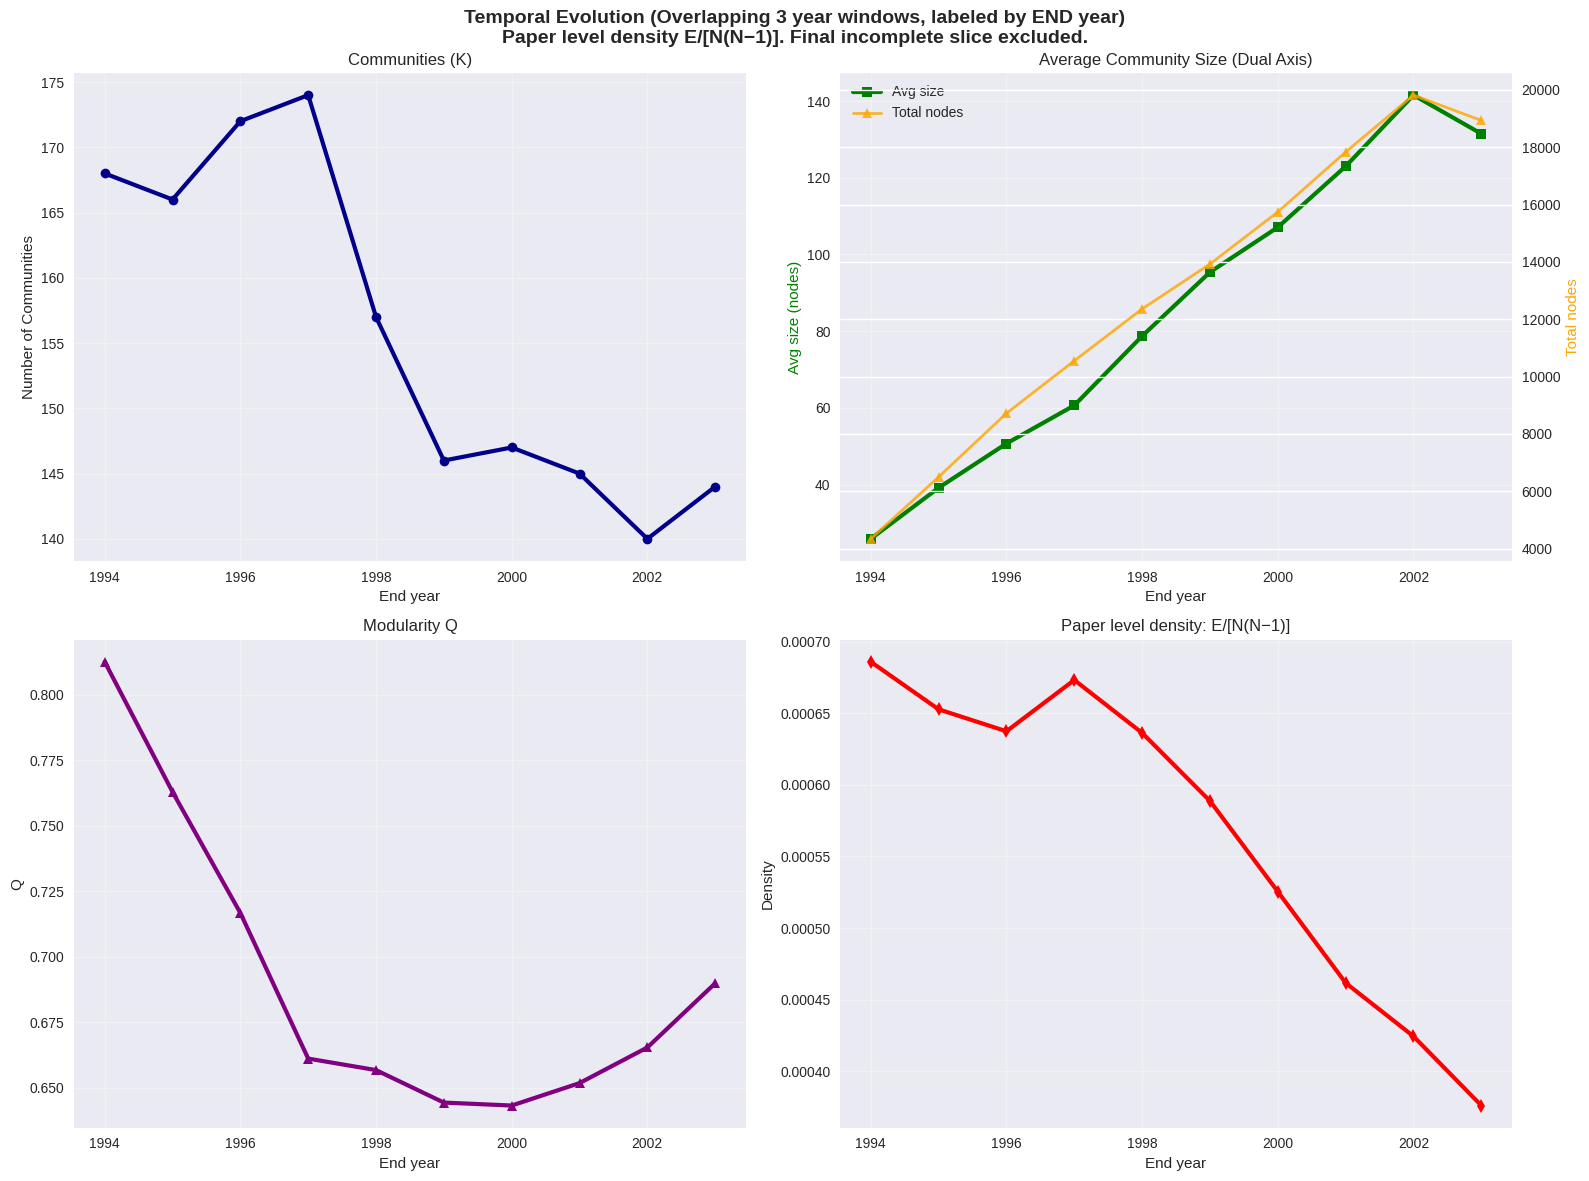

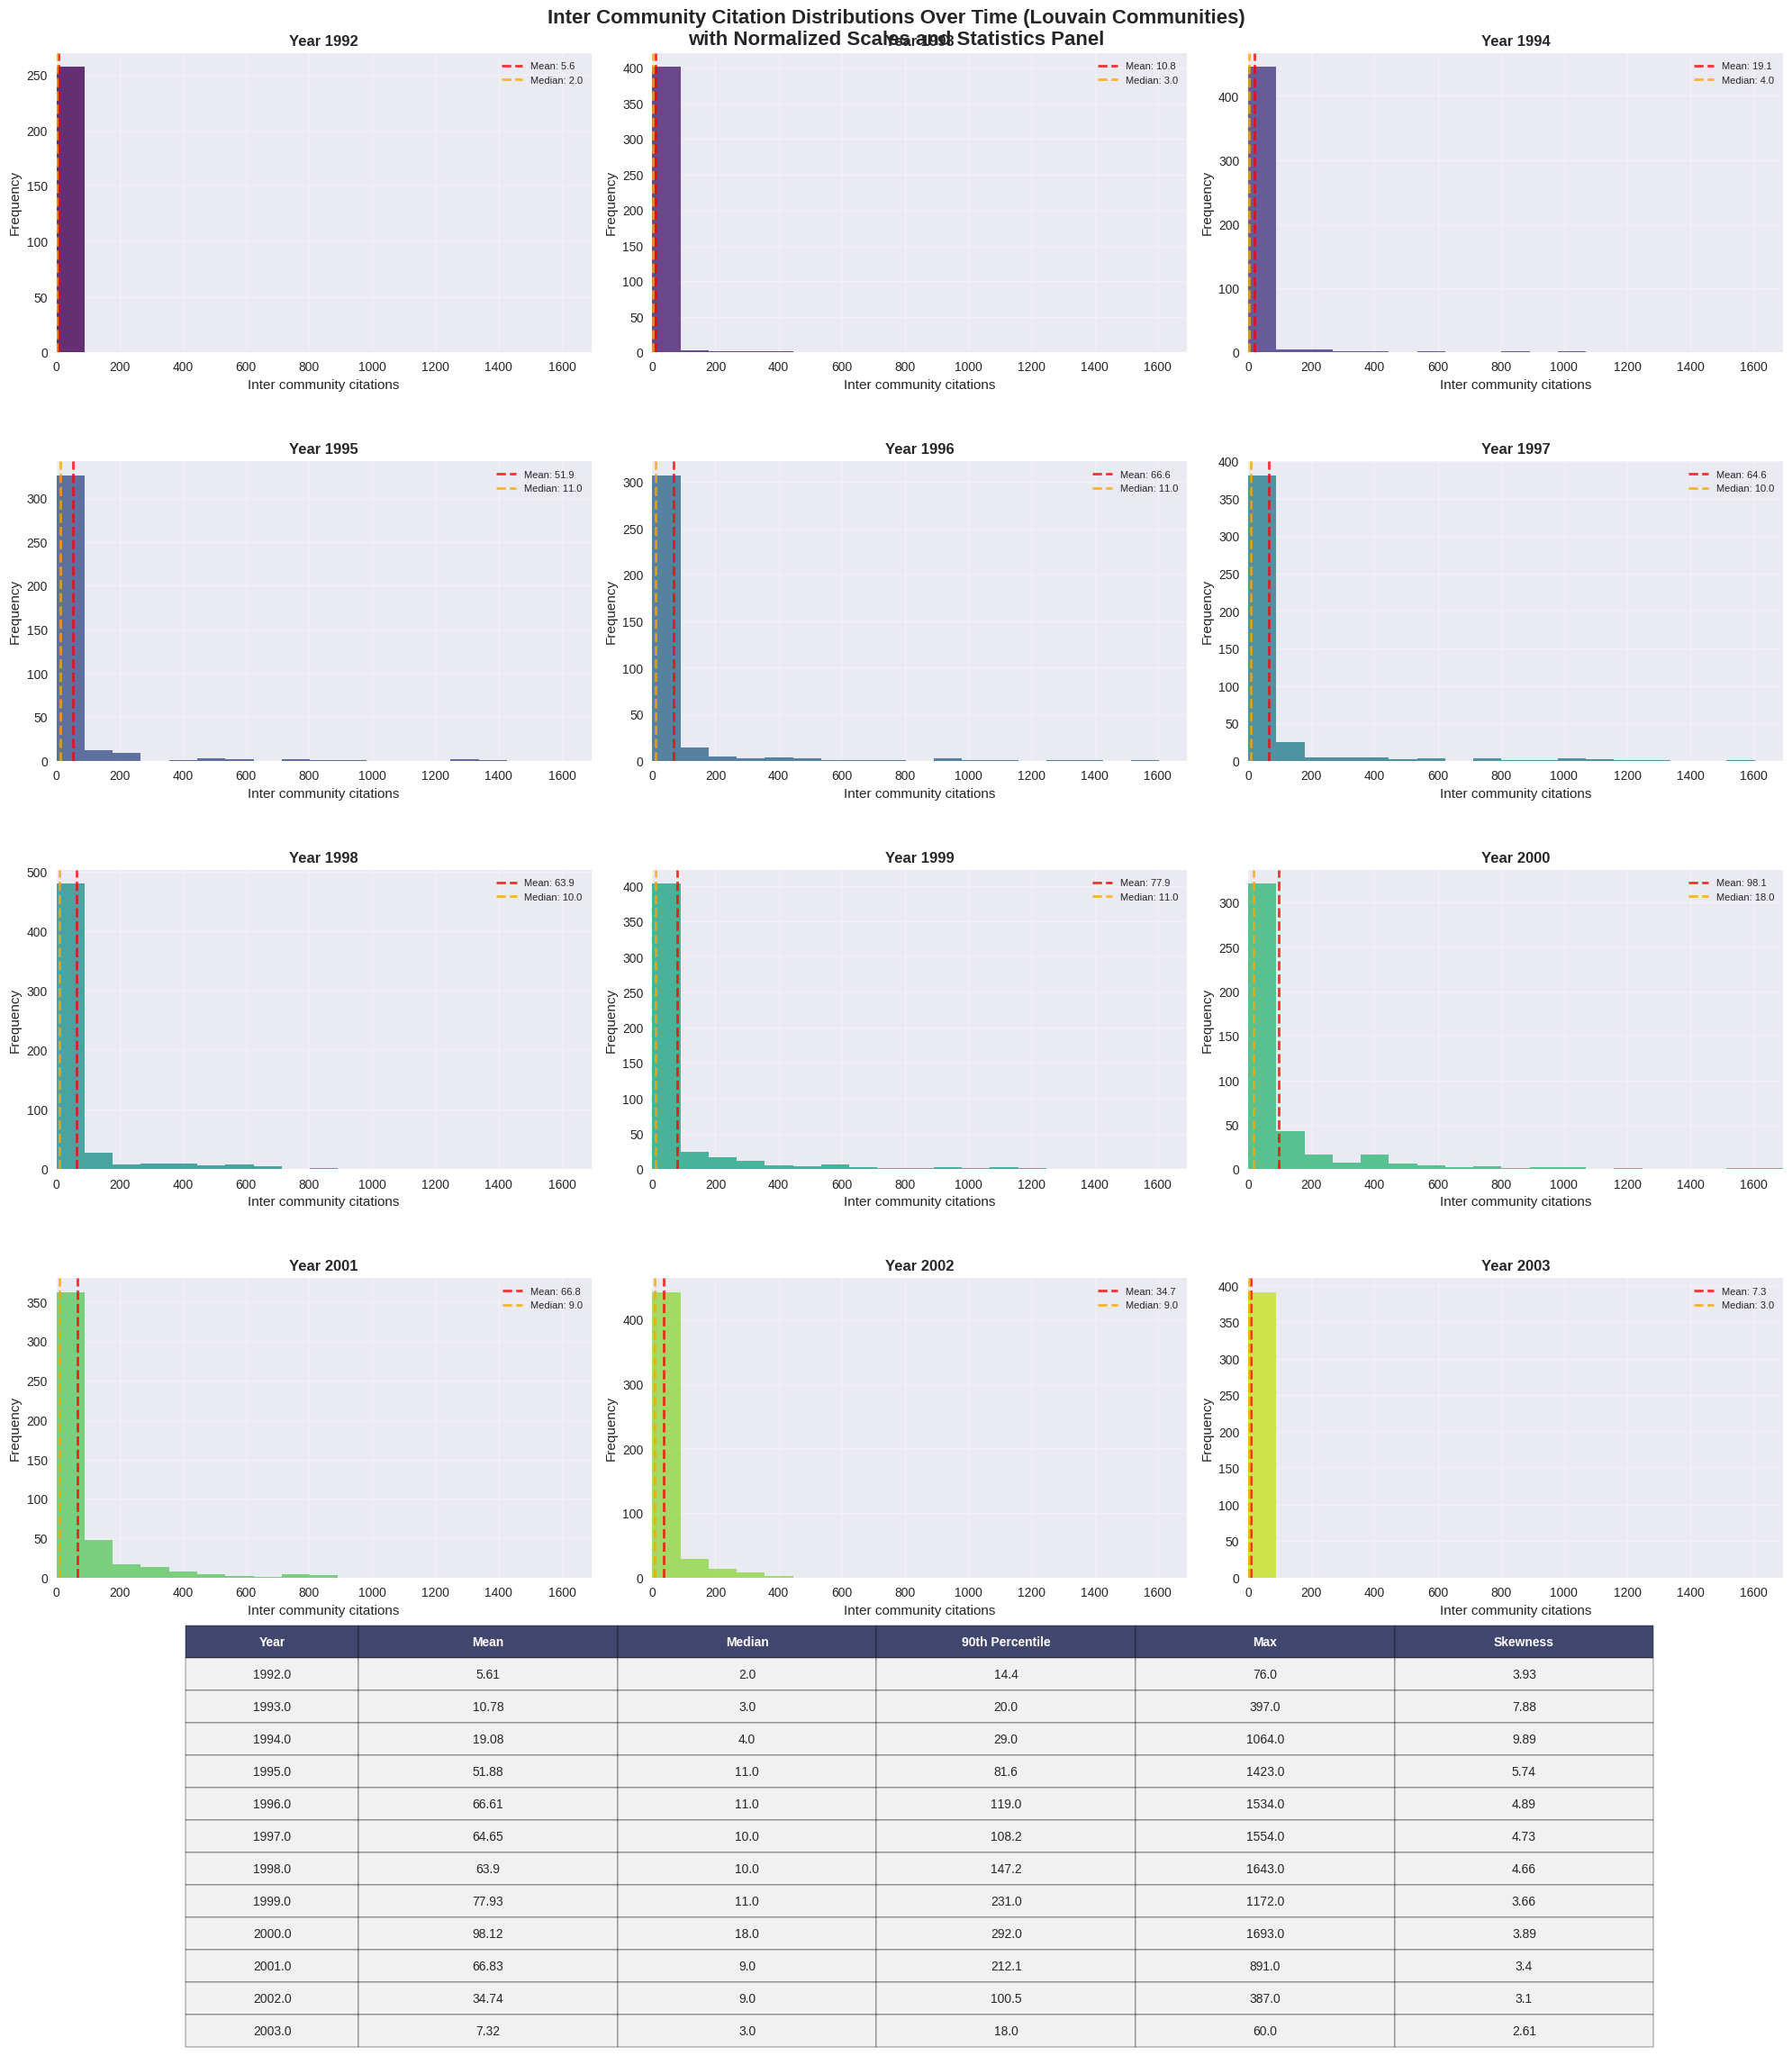

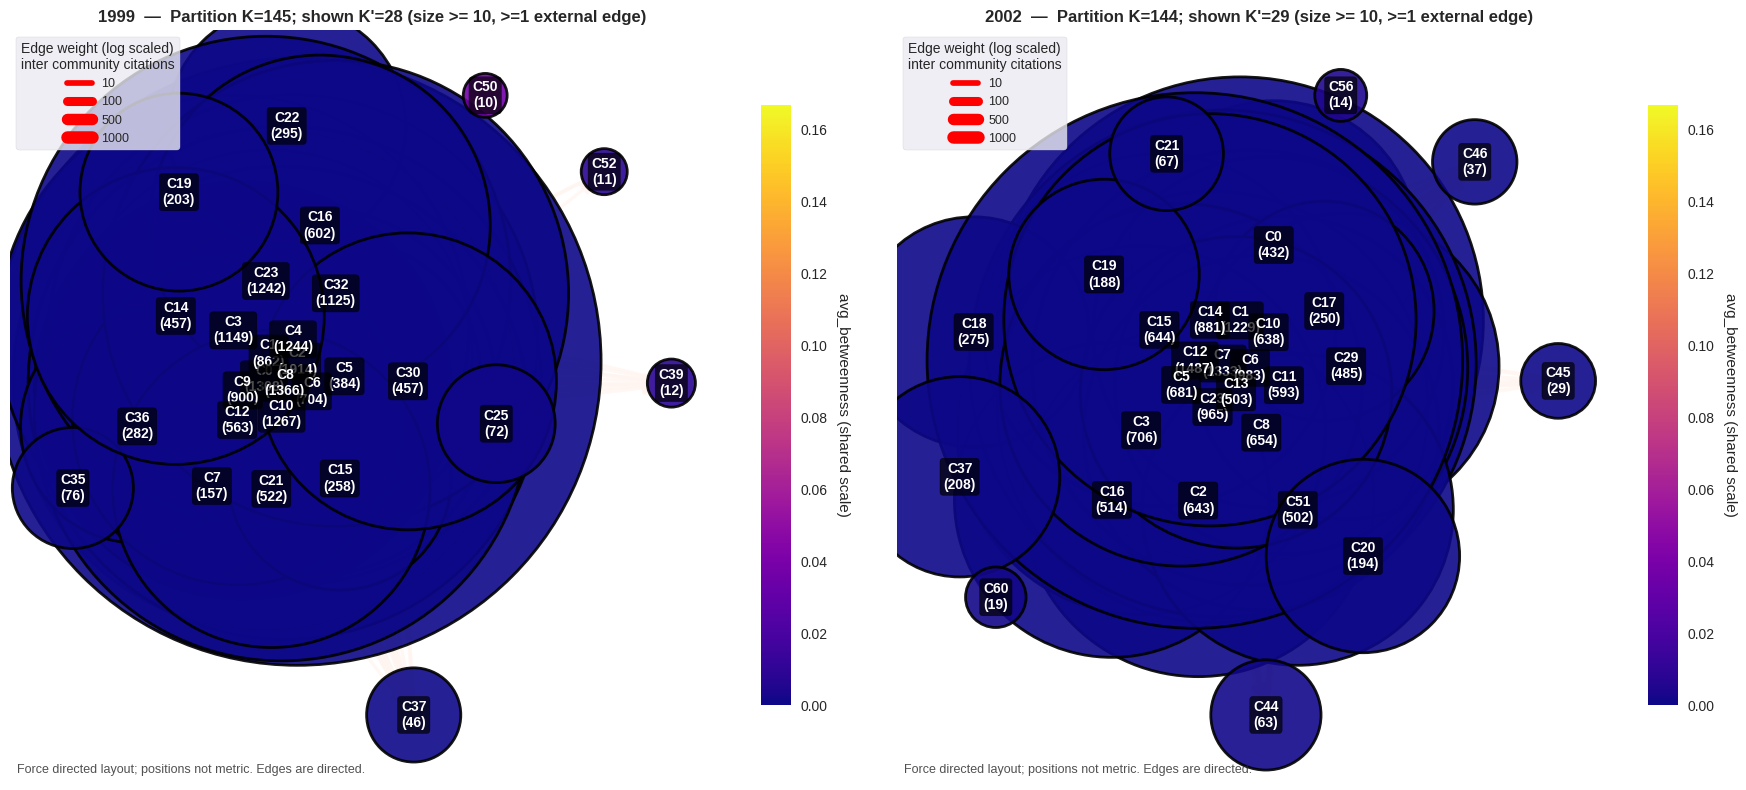

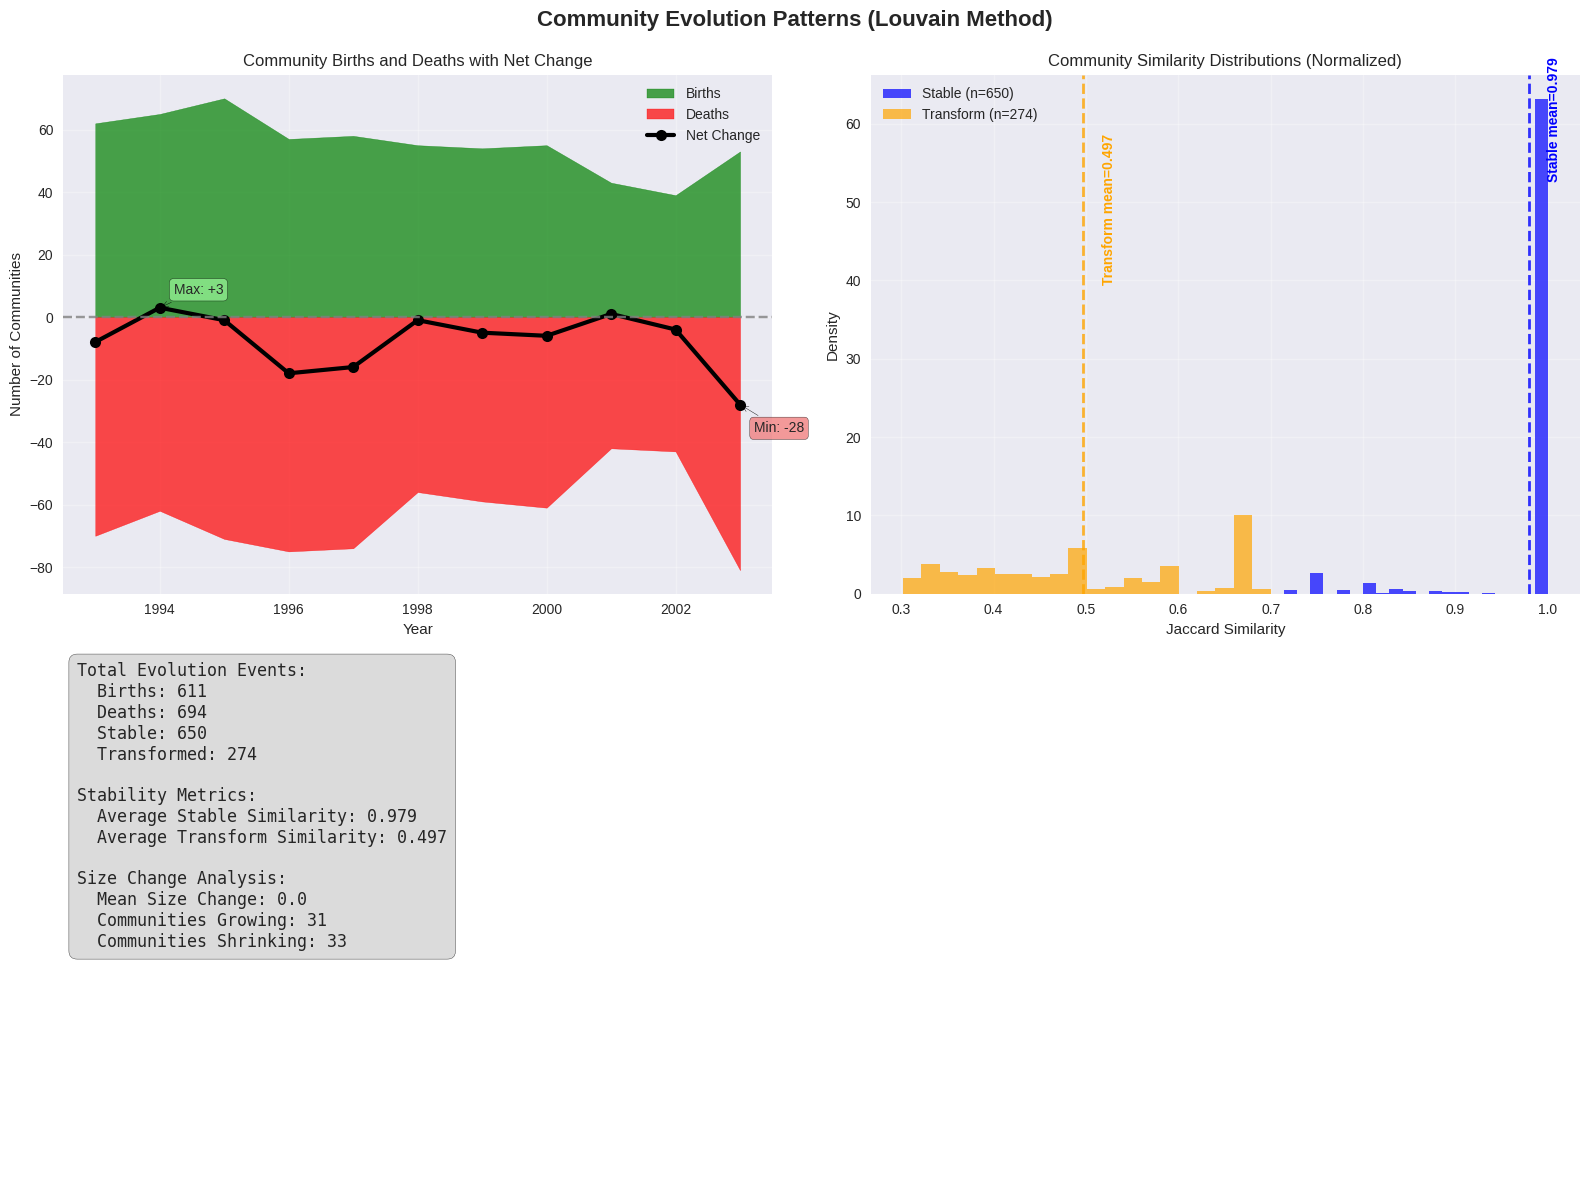

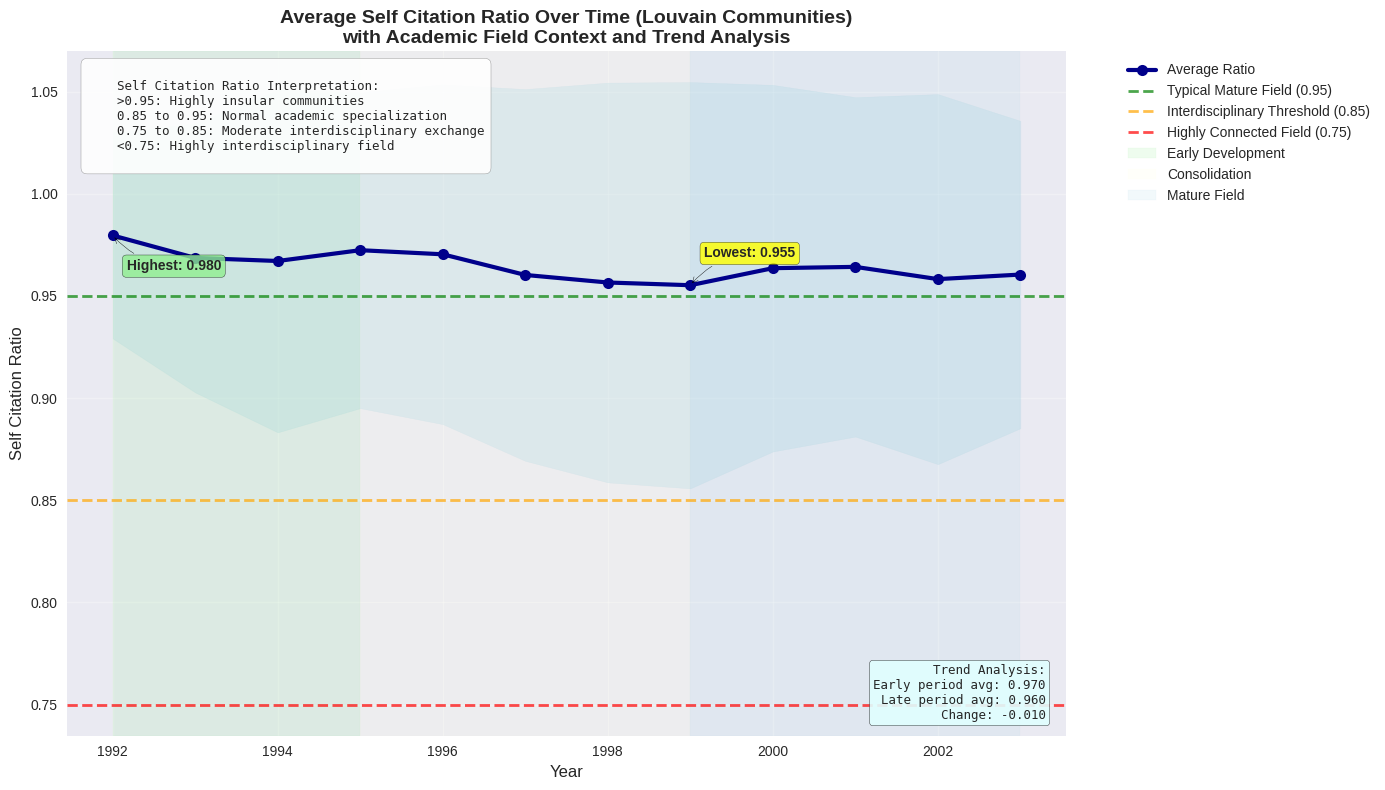

Top exporters (size corrected COIN):
     community  size  exporter_importer_net  importance  dependence
4           4   181               5.339637    6.187845    0.848208
43         43   200               0.967510    1.425000    0.457490
35         35   185               0.686385    0.800000    0.113615
25         25   165               0.650711    0.836364    0.185653
20         20   160               0.513123    1.006250    0.493127
14         14   364               0.466323    1.362637    0.896314
21         21   387               0.425920    0.917313    0.491392
32         32    60               0.415668    0.433333    0.017666
57         57     8               0.375000    0.375000    0.000000
0           0   774               0.356571    4.267442    3.910870
Top importers (size corrected COIN):
     community  size  exporter_importer_net  importance  dependence
1           1   888              -2.320265    4.148649    6.468914
8           8  1166              -2.270672    5.22813

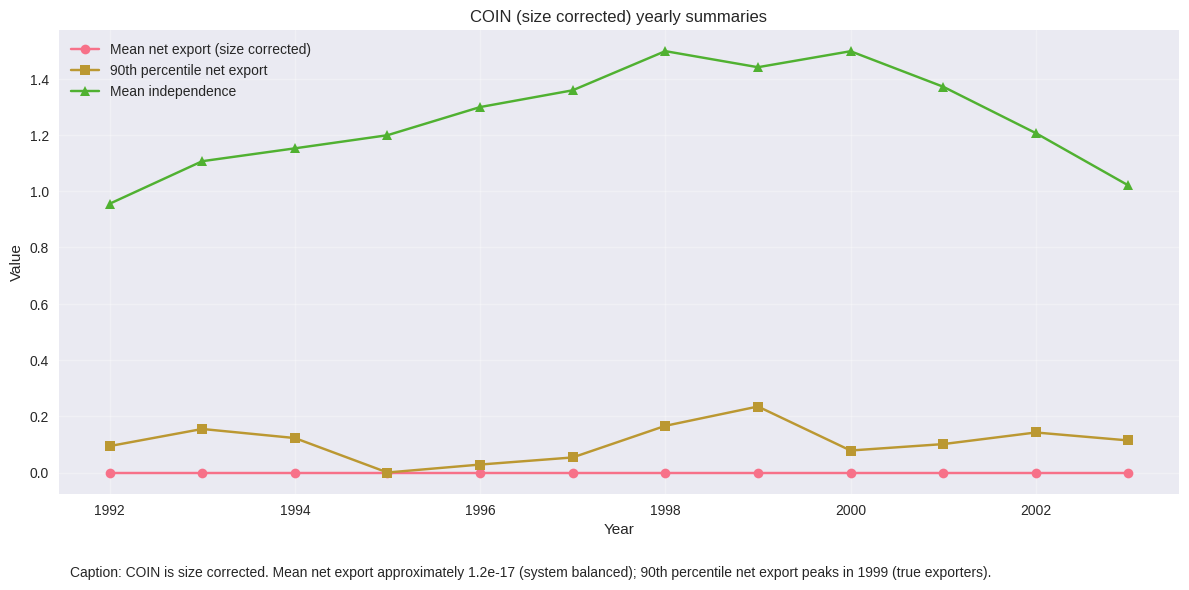

In [5]:
import networkx as nx
import pandas as pd
from collections import defaultdict
import networkx.algorithms.community as nx_comm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import ceil
import warnings
import plotly.express as px
import os
from scipy import stats
from matplotlib.colors import Normalize

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def load_and_preprocess_data():
    """Load citation data and prepare temporal analysis dataset.
    This function merges citation edges with paper metadata for temporal windowing."""
    print("Loading citation network data...")
    edges_df = pd.read_csv("/content/citations.csv")
    papers_df = pd.read_csv("/content/papers_metadata.csv")

    # Merge citation data with publication years
    edges_df = pd.merge(edges_df, papers_df[['paper_id','year']],
                        left_on='citing_paper', right_on='paper_id', how='left')
    edges_df = edges_df.drop(columns=['paper_id'])
    edges_df = edges_df.rename(columns={'citing_paper':'source','cited_paper':'target'})

    # Clean data and establish temporal bounds
    edges_df = edges_df.dropna(subset=['year'])
    year_min, year_max = int(edges_df['year'].min()), int(edges_df['year'].max())
    edges_df['year'] = edges_df['year'].astype(int)
    print(f"Data spans from {year_min} to {year_max}")
    print(f"Loaded {len(edges_df)} citation edges from {edges_df['year'].min()} to {edges_df['year'].max()}")
    return edges_df


def build_yearly_graphs(df, window=3):
    """Construct temporal networks using sliding window approach.
    Creates overlapping time windows to capture community evolution dynamics."""
    print(f"Building yearly graphs with window size {window}...")
    yearly_graphs = {}
    years = sorted(df['year'].unique())
    if not years: return yearly_graphs
    start_year, end_year = int(min(years)), int(max(years))
    print(f"Processing years from {start_year} to {end_year}")

    for start in range(start_year, end_year + 1):
        end_window = min(start + window, end_year + 1)
        window_edges = df[(df['year'] >= start) & (df['year'] < end_window)]
        G = nx.DiGraph()
        if not window_edges.empty:
            G.add_edges_from(window_edges[['source','target']].values)
        yearly_graphs[start] = G
        print(f"  Year {start} (window {start} to {end_window-1}): {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    return yearly_graphs


def detect_communities(G):
    """Apply Louvain community detection with multiple fallback methods.
    Prioritizes modularity optimization but gracefully handles edge cases."""
    if G.number_of_nodes() == 0:
        return {}

    undirected = G.to_undirected()

    try:
        # Primary method: Louvain community detection
        try:
            import community as community_louvain
            if hasattr(community_louvain, 'best_partition'):
                partition = community_louvain.best_partition(undirected)
                print(f"    Louvain detected {len(set(partition.values()))} communities")
                return partition
            else:
                raise AttributeError("best_partition not found in community module")
        except (ImportError, AttributeError):
            try:
                # Alternative import pattern for newer versions
                from community import community_louvain
                partition = community_louvain.best_partition(undirected)
                print(f"    Louvain detected {len(set(partition.values()))} communities")
                return partition
            except (ImportError, AttributeError):
            raise ImportError("No Louvain implementation found")

    except Exception as e:
        print(f"    Louvain failed: {e}")
        print("    Falling back to label propagation...")
        try:
            # Fallback: Label propagation algorithm
            comms = nx_comm.label_propagation_communities(undirected)
            partition = {node: i for i, c in enumerate(comms) for node in c}
            print(f"    Label propagation detected {len(set(partition.values()))} communities")
            return partition
        except Exception as e2:
            print(f"    Label propagation failed: {e2}")
            print("    Assigning individual communities...")
            # Last resort: each node becomes its own community
            return {node: i for i, node in enumerate(G.nodes())}

def jaccard_similarity(a: set, b: set) -> float:
    """Calculate Jaccard similarity coefficient between two sets.
    Measures overlap between community memberships across time periods."""
    u = a | b
    return 0.0 if len(u)==0 else len(a & b)/len(u)

def match_communities(prev_part: dict, curr_part: dict):
    """Track community evolution using similarity matching.
    Links communities across time periods based on member overlap."""
    matches = {}
    prev_comms, curr_comms = defaultdict(set), defaultdict(set)
    for n,c in prev_part.items(): prev_comms[c].add(n)
    for n,c in curr_part.items(): curr_comms[c].add(n)

    for curr_id, curr_nodes in curr_comms.items():
        best_score, best_match = 0.0, None
        for prev_id, prev_nodes in prev_comms.items():
            s = jaccard_similarity(prev_nodes, curr_nodes)
            if s > best_score and s > 0.1:
                best_score, best_match = s, prev_id
        matches[curr_id] = best_match
    return matches

def compute_modularity(G_undirected: nx.Graph, partition: dict) -> float:
    """Calculate modularity score for community partition.
    Measures quality of community structure relative to random expectation."""
    if G_undirected.number_of_nodes()==0 or not partition: return 0.0
    from collections import defaultdict
    comms = defaultdict(set)
    for n,c in partition.items(): comms[c].add(n)
    try:
        return nx_comm.modularity(G_undirected, list(comms.values()))
    except Exception:
        return 0.0

def compute_metrics(G: nx.DiGraph, partition: dict):
    """Calculate comprehensive community characteristics and centrality measures.
    Computes structural properties for each detected community."""
    from collections import defaultdict
    m = defaultdict(dict)
    if not partition: return m
    for cid in set(partition.values()):
        nodes = [n for n,c in partition.items() if c==cid]
        SG = G.subgraph(nodes)
        m[cid]['size'] = len(nodes)
        m[cid]['modularity'] = compute_modularity(G.to_undirected(), partition)
        try:
            betw = nx.betweenness_centrality(SG) if SG.number_of_nodes()>1 else {}
            m[cid]['avg_betweenness'] = (sum(betw.values())/len(betw)) if betw else 0.0
        except Exception:
            m[cid]['avg_betweenness'] = 0.0
        try:
            degc = nx.degree_centrality(SG) if SG.number_of_nodes()>1 else {}
            m[cid]['avg_centrality'] = (sum(degc.values())/len(degc)) if degc else 0.0
        except Exception:
            m[cid]['avg_centrality'] = 0.0
    return m

def build_meta_graph(G: nx.DiGraph, partition: dict) -> nx.DiGraph:
    """Construct meta graph representing inter community citation flows.
    Aggregates individual citations into community level connections."""
    meta_edges = defaultdict(int)
    for u,v in G.edges():
        cu, cv = partition.get(u), partition.get(v)
        if cu is not None and cv is not None and cu != cv:
            meta_edges[(cu,cv)] += 1
    MG = nx.DiGraph()
    for (cu,cv), w in meta_edges.items():
        MG.add_edge(cu, cv, weight=w)
    return MG

def compute_self_citation_ratio(G: nx.DiGraph, partition: dict):
    """Calculate internal versus external citation ratios for communities.
    Higher ratios indicate more insular research communities."""
    stats = defaultdict(lambda: {'intra':0, 'total':0})
    for u,v in G.edges():
        cu, cv = partition.get(u), partition.get(v)
        if cu is None or cv is None: continue
        stats[cu]['total'] += 1
        if cu==cv: stats[cu]['intra'] += 1
    return {c: d['intra']/d['total'] for c,d in stats.items() if d['total']>0}

def meta_edges_for_year(G: nx.DiGraph, partition: dict) -> pd.DataFrame:
    """Extract inter community citation edges for single time period.
    Creates structured data for temporal meta network analysis."""
    if not partition or G.number_of_edges()==0:
        return pd.DataFrame(columns=['src_comm','dst_comm','weight'])
    edge_counts = {}
    for u,v in G.edges():
        cu,cv = partition.get(u), partition.get(v)
        if cu is None or cv is None or cu==cv: continue
        edge_counts[(cu,cv)] = edge_counts.get((cu,cv), 0) + 1
    return pd.DataFrame(
        [{'src_comm':cu,'dst_comm':cv,'weight':w} for (cu,cv),w in edge_counts.items()]
    )

def compute_meta_over_time(yearly_graphs: dict[int, nx.DiGraph],
                           yearly_partitions: dict[int, dict]) -> dict[int, pd.DataFrame]:
    """Generate time series of meta graph edge data.
    Tracks inter community citation patterns across all time periods."""
    meta_by_year = {}
    for year in sorted(yearly_graphs.keys()):
        meta_by_year[year] = meta_edges_for_year(yearly_graphs[year], yearly_partitions.get(year, {}))
    return meta_by_year

def exporters_importers_summary(meta_by_year: dict[int, pd.DataFrame]) -> pd.DataFrame:
    """Identify communities that export versus import knowledge over time.
    Calculates net citation flows to classify research community roles."""
    rows = []
    for year, df in meta_by_year.items():
        if df is None or df.empty: continue
        out_s = df.groupby("src_comm")["weight"].sum().rename("out_strength")
        in_s  = df.groupby("dst_comm")["weight"].sum().rename("in_strength")
        comms = pd.Index(sorted(set(out_s.index) | set(in_s.index)), name="community")
        tmp = pd.DataFrame(index=comms)
        tmp["year"] = year
        tmp["out_strength"] = out_s.reindex(comms, fill_value=0).values
        tmp["in_strength"]  = in_s.reindex(comms, fill_value=0).values
        tmp["net_export"]   = tmp["out_strength"] - tmp["in_strength"]
        rows.append(tmp.reset_index())
    return pd.concat(rows, ignore_index=True) if rows else pd.DataFrame(columns=["year","community","out_strength","in_strength","net_export"])

def plot_intercommunity_distributions(meta_by_year: dict[int, pd.DataFrame]):
    """Visualize citation weight distributions across time periods.
    Shows evolution of inter community collaboration intensity patterns."""
    years = [y for y in sorted(meta_by_year.keys()) if not meta_by_year[y].empty]
    if not years:
        print("No inter community data to plot.")
        return

    # Create summary statistics for temporal comparison
    stats_data = []
    all_weights = []

    for year in years:
        weights = meta_by_year[year]["weight"].values
        if len(weights):
            stats_data.append({
                'Year': year,
                'Mean': np.mean(weights),
                'Median': np.median(weights),
                '90th Percentile': np.percentile(weights, 90),
                'Max': np.max(weights),
                'Skewness': stats.skew(weights)
            })
            all_weights.extend(weights)

    stats_df = pd.DataFrame(stats_data)

    # Determine global scale for consistent comparison across years
    global_max = max(all_weights) if all_weights else 100

    # Create comprehensive subplot layout
    n_years = len(years)
    cols = 3
    rows = ceil(n_years / cols)

    fig = plt.figure(figsize=(20, 4.8 * rows + 4))

    # Create histograms with consistent scaling for temporal comparison
    for i, year in enumerate(years):
        ax = plt.subplot(rows + 1, cols, i + 1)
        weights = meta_by_year[year]["weight"].values

        # Use consistent bins across all time periods
        bins = np.linspace(0, global_max, 20)
        n, bins_edges, patches = ax.hist(weights, bins=bins, alpha=0.8, color=plt.cm.viridis(i/len(years)))

        # Add vertical reference lines for key statistics
        if len(weights):
            mean_val = np.mean(weights)
            median_val = np.median(weights)
            ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, alpha=0.8, label=f'Mean: {mean_val:.1f}')
            ax.axvline(median_val, color='orange', linestyle='--', linewidth=2, alpha=0.8, label=f'Median: {median_val:.1f}')

        ax.set_title(f"Year {year}", fontweight='bold')
        ax.set_xlabel("Inter community citations")
        ax.set_ylabel("Frequency")
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, global_max)

    # Hide empty subplot positions
    for j in range(n_years, rows * cols):
        ax = plt.subplot(rows + 1, cols, j + 1)
        ax.axis('off')

    # Add comprehensive statistics table at bottom
    if not stats_df.empty:
        ax_table = plt.subplot(rows + 1, 1, rows + 1)
        ax_table.axis('tight')
        ax_table.axis('off')

        # Create professionally formatted statistics table
        table_data = stats_df.round(2).values.tolist()
        table = ax_table.table(cellText=table_data,
                              colLabels=stats_df.columns,
                              cellLoc='center',
                              loc='center',
                              colWidths=[0.1, 0.15, 0.15, 0.15, 0.15, 0.15])

        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 2)

        # Apply professional table styling
        for i in range(len(stats_df.columns)):
            table[(0, i)].set_facecolor('#40466e')
            table[(0, i)].set_text_props(weight='bold', color='white')

        # Alternate row coloring for readability
        for i in range(1, len(stats_data) + 1):
            for j in range(len(stats_df.columns)):
                table[(i, j)].set_facecolor('#f1f1f2')

    plt.suptitle("Inter Community Citation Distributions Over Time (Louvain Communities)\nwith Normalized Scales and Statistics Panel",
                 fontsize=16, fontweight="bold", y=0.98)
    plt.tight_layout()
    plt.show()

def plot_meta_graphs_all_years(yearly_graphs, yearly_partitions, yearly_metrics, max_years=12):
    """Generate detailed visualizations of inter community networks across time.
    Creates publication ready meta graph layouts with comprehensive annotations."""
    years = sorted(yearly_graphs.keys())
    if not years:
        print("No years to plot for meta graphs.")
        return

    selected_years = years[::max(1, len(years)//max_years)][:max_years]
    print(f"Plotting {len(selected_years)} individual meta graphs...")

    for year in selected_years:
        G = yearly_graphs[year]
        part = yearly_partitions.get(year, {})
        metrics = yearly_metrics.get(year, {})

        if not part:
            print(f"Year {year}: No communities detected")
            continue

        metaG = build_meta_graph(G, part)

        if metaG.number_of_nodes() == 0:
            print(f"Year {year}: No inter community edges")
            continue

        # Create individual figure with generous sizing for clarity
        fig, ax = plt.subplots(figsize=(14, 10))

        # Use spring layout for optimal node positioning
        pos = nx.spring_layout(metaG, k=3, iterations=50, seed=42)

        # Calculate community sizes for proportional node scaling
        community_sizes = {}
        for node, comm in part.items():
            community_sizes[comm] = community_sizes.get(comm, 0) + 1

        # Scale node sizes proportionally to community membership
        node_sizes = [community_sizes.get(node, 1) * 100 for node in metaG.nodes()]

        # Color nodes by internal connectivity metrics
        node_colors = []
        for node in metaG.nodes():
            if node in metrics and 'avg_betweenness' in metrics[node]:
                node_colors.append(metrics[node]['avg_betweenness'])
            else:
                node_colors.append(0.1)

        # Draw nodes with enhanced visual styling
        nodes = nx.draw_networkx_nodes(metaG, pos, ax=ax,
                                      node_size=node_sizes,
                                      node_color=node_colors,
                                      cmap=plt.cm.plasma,
                                      alpha=0.8,
                                      linewidths=3,
                                      edgecolors='black')

        # Calculate edge weights and visual thickness mapping
        weights = [metaG[u][v]['weight'] for u, v in metaG.edges()]
        if weights:
            max_w = max(weights)
            min_w = min(weights)
            # Normalize edge weights for visual thickness (enhanced range for visibility)
            edge_widths = [2 + 6 * (w - min_w) / (max_w - min_w) if max_w > min_w else 4 for w in weights]

            edges = nx.draw_networkx_edges(metaG, pos, ax=ax,
                                         width=edge_widths,
                                         edge_color=weights,
                                         edge_cmap=plt.cm.Reds,
                                         alpha=0.8,
                                         arrows=True,
                                         arrowstyle='-|>',
                                         arrowsize=25,
                                         connectionstyle="arc3,rad=0.1")

        # Create informative node labels showing community ID and size
        labels = {}
        for node in metaG.nodes():
            size = community_sizes.get(node, 0)
            labels[node] = f'C{node}\n({size} nodes)'

        nx.draw_networkx_labels(metaG, pos, labels, ax=ax, font_size=11,
                               font_weight='bold', font_color='white',
                               bbox=dict(boxstyle="round,pad=0.3",
                                        facecolor='black', alpha=0.7))

        # Add edge weight labels for strongest connections
        edge_labels = {}
        for u, v in metaG.edges():
            weight = metaG[u][v]['weight']
            if weight > np.percentile(weights, 75):  # Show top quartile edge weights
                edge_labels[(u, v)] = str(weight)

        if edge_labels:
            nx.draw_networkx_edge_labels(metaG, pos, edge_labels, ax=ax, font_size=9,
                                        font_color='red', font_weight='bold',
                                        bbox=dict(boxstyle="round,pad=0.2",
                                                 facecolor='white', alpha=0.8))

        # Calculate summary statistics for title annotation
        total_inter_citations = sum(weights) if weights else 0
        avg_weight = np.mean(weights) if weights else 0

        ax.set_title(f'Year {year} Meta Graph (Louvain Communities)\n'
                    f'{metaG.number_of_nodes()} communities, {metaG.number_of_edges()} inter community connections\n'
                    f'Total inter community citations: {total_inter_citations}, Average: {avg_weight:.1f}\n'
                    f'Node size proportional to Community size, Edge thickness proportional to Citation count',
                    fontsize=14, fontweight='bold', pad=20)

        # Add colorbar for node coloring interpretation
        if nodes is not None and len(set(node_colors)) > 1:
            sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma,
                                     norm=plt.Normalize(vmin=min(node_colors),
                                                       vmax=max(node_colors)))
            sm.set_array([])
            cbar = fig.colorbar(sm, ax=ax, shrink=0.8, pad=0.1)
            cbar.set_label('Average Betweenness Centrality', rotation=270,
                          labelpad=20, fontsize=12, fontweight='bold')

        # Create informative legend for edge weights and symbols
        if weights:
            legend_elements = [
                plt.Line2D([0], [0], color='red', lw=2, alpha=0.8,
                          label=f'Min citations: {min_w}'),
                plt.Line2D([0], [0], color='red', lw=6, alpha=0.8,
                          label=f'Max citations: {max_w}'),
                plt.Line2D([0], [0], marker='o', color='w',
                          markerfacecolor='purple', markersize=8, alpha=0.8,
                          label='Community (size proportional to nodes)', linestyle='None')
            ]
            ax.legend(handles=legend_elements, loc='upper left',
                     bbox_to_anchor=(0.02, 0.98), fontsize=10)

        # Add comprehensive network statistics as text annotation
        stats_text = f"""Network Statistics:
        Communities: {metaG.number_of_nodes()}
        Inter community edges: {metaG.number_of_edges()}
        Total nodes: {G.number_of_nodes()}
        Total edges: {G.number_of_edges()}
        Density: {nx.density(metaG):.3f}
        Largest community: {max(community_sizes.values())} nodes"""

        ax.text(0.98, 0.02, stats_text, transform=ax.transAxes,
               verticalalignment='bottom', horizontalalignment='right',
               fontsize=10, fontfamily='monospace',
               bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray',
                        alpha=0.9, edgecolor='black'))

        ax.axis('off')
        plt.tight_layout()
        plt.show()

        # Print detailed console summary for each year
        print(f"\nYear {year} Summary:")
        print(f"  {metaG.number_of_nodes()} communities with inter community connections")
        print(f"  {total_inter_citations} total inter community citations")
        print(f"  Largest community: {max(community_sizes.values())} nodes")
        print(f"  Most connected communities: {sorted([(n, metaG.degree(n)) for n in metaG.nodes()], key=lambda x: x[1], reverse=True)[:3]}")


def plot_exporter_importer_bars(summary_df: pd.DataFrame, year: int, top=10):
    """Create interactive bar charts showing knowledge flow patterns.
    Identifies communities that primarily export versus import citations."""
    if summary_df is None or summary_df.empty:
        print("No exporter importer data available.")
        return
    dfy = summary_df[summary_df['year']==year].copy()
    if dfy.empty:
        print(f"No exporter importer data for year {year}.")
        return
    top_exp = dfy.sort_values('net_export', ascending=False).head(top)
    top_imp = dfy.sort_values('net_export', ascending=True).head(top)
    fig1 = px.bar(top_exp, x='community', y='net_export', title=f"Top net exporters (Louvain) in {year}", text='net_export')
    fig2 = px.bar(top_imp, x='community', y='net_export', title=f"Top net importers (Louvain) in {year}", text='net_export')
    fig1.show()
    fig2.show()

def analyze_community_evolution_patterns(yearly_partitions, community_matches):
    """Track community lifecycle events including birth, death, and transformation.
    Quantifies structural changes in research community organization over time."""
    evolution = {'birth': [], 'death': [], 'merge': [], 'split': [], 'stable': [], 'transform': []}
    years = sorted(yearly_partitions.keys())
    for i in range(1, len(years)):
        prev_year, curr_year = years[i-1], years[i]
        prev_part, curr_part = yearly_partitions[prev_year], yearly_partitions[curr_year]
        matches = community_matches.get(curr_year, {})
        if not prev_part or not curr_part: continue
        prev_comms, curr_comms = defaultdict(set), defaultdict(set)
        for n,c in prev_part.items(): prev_comms[c].add(n)
        for n,c in curr_part.items(): curr_comms[c].add(n)

        # Classify evolution patterns based on member overlap similarity
        for curr_id, curr_nodes in curr_comms.items():
            prev_id = matches.get(curr_id)
            if prev_id is None:
                evolution['birth'].append({'year': curr_year, 'community': curr_id, 'size': len(curr_nodes)})
            else:
                sim = jaccard_similarity(prev_comms[prev_id], curr_nodes)
                bucket = 'stable' if sim > 0.7 else ('transform' if sim > 0.3 else None)
                if bucket:
                    evolution[bucket].append({
                        'year': curr_year,
                        'prev_community': prev_id,
                        'curr_community': curr_id,
                        'similarity': sim,
                        'size_change': len(curr_nodes) - len(prev_comms[prev_id]),
                    })
        matched_prev = set(matches.values())
        for prev_id in prev_comms:
            if prev_id not in matched_prev:
                evolution['death'].append({'year': curr_year, 'community': prev_id, 'size': len(prev_comms[prev_id])})
    return evolution

def plot_evolution_patterns(evolution):
    """Create comprehensive visualization of community evolution dynamics.
    Shows birth death patterns and stability metrics across temporal windows."""
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    # Prepare temporal data for community births and deaths
    births_by_year = pd.Series([p['year'] for p in evolution['birth']]).value_counts().sort_index()
    deaths_by_year = pd.Series([p['year'] for p in evolution['death']]).value_counts().sort_index()
    all_years = sorted(set(list(births_by_year.index) + list(deaths_by_year.index)))
    births_aligned = births_by_year.reindex(all_years, fill_value=0)
    deaths_aligned = deaths_by_year.reindex(all_years, fill_value=0)
    net_change = births_aligned - deaths_aligned

    # Extract similarity metrics for stability analysis
    stable_sim = [p['similarity'] for p in evolution['stable']]
    transform_sim = [p['similarity'] for p in evolution['transform']]
    size_changes = [p['size_change'] for p in evolution['stable'] if 'size_change' in p]

    # Create comprehensive multi panel visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Community Evolution Patterns (Louvain Method)', fontsize=16, fontweight='bold')

    # Panel 1: Community births, deaths, and net change over time
    ax1 = axes[0, 0]
    ax1.fill_between(all_years, 0, births_aligned, alpha=0.7, color='green', label='Births')
    ax1.fill_between(all_years, 0, -deaths_aligned, alpha=0.7, color='red', label='Deaths')
    ax1.plot(all_years, net_change, color='black', linewidth=3, marker='o', markersize=8, label='Net Change')
    ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.8)

    # Annotate extreme values for interpretability
    if len(net_change):
        max_net_idx = int(np.argmax(net_change))
        min_net_idx = int(np.argmin(net_change))
        ax1.annotate(f'Max: +{net_change.iloc[max_net_idx]}',
                     xy=(all_years[max_net_idx], net_change.iloc[max_net_idx]),
                     xytext=(10, 10), textcoords='offset points',
                     bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.8),
                     arrowprops=dict(arrowstyle='->'))
        if net_change.iloc[min_net_idx] < 0:
            ax1.annotate(f'Min: {net_change.iloc[min_net_idx]}',
                         xy=(all_years[min_net_idx], net_change.iloc[min_net_idx]),
                         xytext=(10, -20), textcoords='offset points',
                         bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.8),
                         arrowprops=dict(arrowstyle='->'))
    ax1.set_title('Community Births and Deaths with Net Change')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Number of Communities')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Panel 2: Community similarity distributions for stable versus transformed communities
    ax2 = axes[0, 1]
    if stable_sim:
        ax2.hist(stable_sim, bins=20, alpha=0.7, color='blue', label=f'Stable (n={len(stable_sim)})', density=True)
        sm = float(np.mean(stable_sim))
        ax2.axvline(sm, color='blue', linestyle='--', linewidth=2, alpha=0.8)
        ax2.text(sm + 0.02, ax2.get_ylim()[1] * 0.8, f'Stable mean={sm:.3f}',
                 rotation=90, color='blue', fontweight='bold')
    if transform_sim:
        ax2.hist(transform_sim, bins=20, alpha=0.7, color='orange', label=f'Transform (n={len(transform_sim)})', density=True)
        tm = float(np.mean(transform_sim))
        ax2.axvline(tm, color='orange', linestyle='--', linewidth=2, alpha=0.8)
        ax2.text(tm + 0.02, ax2.get_ylim()[1] * 0.6, f'Transform mean={tm:.3f}',
                 rotation=90, color='orange', fontweight='bold')
    ax2.set_title('Community Similarity Distributions (Normalized)')
    ax2.set_xlabel('Jaccard Similarity')
    ax2.set_ylabel('Density')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Panel 3: Comprehensive summary statistics
    ax3 = axes[1, 0]
    ax3.axis('off')
    summary_lines = [
        "Total Evolution Events:",
        f"  Births: {len(evolution['birth'])}",
        f"  Deaths: {len(evolution['death'])}",
        f"  Stable: {len(evolution['stable'])}",
        f"  Transformed: {len(evolution['transform'])}",
        "",
        "Stability Metrics:",
        f"  Average Stable Similarity: {np.mean(stable_sim):.3f}" if stable_sim else "  Average Stable Similarity: N/A",
        f"  Average Transform Similarity: {np.mean(transform_sim):.3f}" if transform_sim else "  Average Transform Similarity: N/A",
        "",
        "Size Change Analysis:",
        f"  Mean Size Change: {np.mean(size_changes):.1f}" if size_changes else "  Mean Size Change: N/A",
        f"  Communities Growing: {sum(1 for x in size_changes if x > 0)}" if size_changes else "  Communities Growing: N/A",
        f"  Communities Shrinking: {sum(1 for x in size_changes if x < 0)}" if size_changes else "  Communities Shrinking: N/A",
    ]
    ax3.text(0.02, 0.98, "\n".join(summary_lines),
             transform=ax3.transAxes, va='top', fontsize=12, fontfamily='monospace',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8))

    # Panel 4: Reserved for future extensions
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()


def global_metric_bounds(yearly_metrics: dict[int, dict],
                         metric_key: str = 'avg_betweenness',
                         q_hi: float = 0.99):
    """Calculate global bounds for metrics across all years and communities.
    Ensures consistent color scaling in comparative visualizations."""
    vals = []
    for y, mdict in yearly_metrics.items():
        for cid, m in mdict.items():
            v = m.get(metric_key, None)
            if v is not None and np.isfinite(v):
                vals.append(float(v))
    if not vals: return 0.0, 1.0
    vals = np.array(vals, float)
    vmin = 0.0
    vmax = np.quantile(vals, q_hi) if (vals > 0).any() else 1e-6
    if vmax <= vmin: vmax = vmin + 1e-6
    return vmin, float(vmax)

def plot_meta_graphs_peak_vs_post(yearly_graphs, yearly_partitions, yearly_metrics,
                                  year_peak: int, year_post: int,
                                  size_threshold: int = 10,
                                  metric_key: str = 'avg_betweenness',
                                  share_colorbar: bool = True):
    """Compare meta graph structures between peak and post peak periods.
    Filters communities by size and connectivity for focused analysis."""
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.lines as mlines

    # Calculate shared colorbar bounds across years for consistent comparison
    if share_colorbar:
        vmin_glob, vmax_glob = global_metric_bounds(yearly_metrics, metric_key=metric_key, q_hi=0.99)
    else:
        vmin_glob, vmax_glob = None, None

    fig, axs = plt.subplots(1, 2, figsize=(18, 8))

    def draw_one(ax, year):
        """Draw single year meta graph with comprehensive styling."""
        G = yearly_graphs[year]
        part = yearly_partitions.get(year, {})
        metrics = yearly_metrics.get(year, {})

        if not part:
            ax.set_title(f"{year}: no communities")
            ax.axis('off')
            return

        K = len(set(part.values()))
        metaG = build_meta_graph(G, part)
        if metaG.number_of_nodes() == 0:
            ax.set_title(f"{year}: no inter community edges")
            ax.axis('off')
            return

        # Calculate community sizes for filtering and visualization
        size_by_comm = {}
        for cid in set(part.values()):
            if cid in metrics and 'size' in metrics[cid]:
                size_by_comm[cid] = metrics[cid]['size']
            else:
                size_by_comm[cid] = sum(1 for v in part.values() if v == cid)

        # Apply size and degree filters to focus on significant communities
        keep = [n for n in metaG.nodes()
                if size_by_comm.get(n, 0) >= size_threshold and (metaG.degree(n) > 0)]
        H = metaG.subgraph(keep).copy()
        Kprime = H.number_of_nodes()

        if Kprime == 0:
            ax.set_title(f"{year}: no nodes pass filters")
            ax.axis('off')
            return

        # Extract node colors from centrality metrics
        node_colors = [float(metrics.get(n, {}).get(metric_key, 0.0)) for n in H.nodes()]
        node_sizes  = [size_by_comm.get(n, 1) * 100 for n in H.nodes()]

        # Set color limits based on global or local scaling
        if vmin_glob is None or vmax_glob is None:
            vmin_use = min(node_colors) if node_colors else 0.0
            vmax_use = max(node_colors) if node_colors else 1.0
            if vmax_use <= vmin_use: vmax_use = vmin_use + 1e-6
            cbar_label = f'{metric_key} (per panel scale)'
        else:
            vmin_use, vmax_use = vmin_glob, vmax_glob
            cbar_label = f'{metric_key} (shared scale)'

        # Generate layout positions using spring algorithm
        pos = nx.spring_layout(H, k=3, iterations=50, seed=42)

        # Draw nodes with metric based coloring
        nodes = nx.draw_networkx_nodes(
            H, pos, ax=ax,
            node_size=node_sizes,
            node_color=node_colors,
            cmap=plt.cm.plasma,
            vmin=vmin_use, vmax=vmax_use,
            alpha=0.9, linewidths=2, edgecolors='black'
        )

        # Apply logarithmic scaling to edge widths for better visualization
        weights = [H[u][v]['weight'] for u, v in H.edges()]
        if weights:
            def w2width(w):
                """Convert weight to visual width using logarithmic scaling."""
                return 1.5 + 2.5 * np.log10(w + 1.0)
            widths = [w2width(w) for w in weights]
            nx.draw_networkx_edges(H, pos, ax=ax,
                                   width=widths,
                                   edge_color=weights,
                                   edge_cmap=plt.cm.Reds,
                                   alpha=0.8,
                                   arrows=True,
                                   arrowstyle='-|>',
                                   arrowsize=20,
                                   connectionstyle="arc3,rad=0.08")

        # Create informative node labels
        labels = {n: f"C{n}\n({size_by_comm.get(n,0)})" for n in H.nodes()}
        nx.draw_networkx_labels(H, pos, labels, ax=ax, font_size=10,
                                font_weight='bold', font_color='white',
                                bbox=dict(boxstyle="round,pad=0.25", facecolor='black', alpha=0.7))

        ax.set_title(f"{year}  —  Partition K={K}; shown K'={Kprime} (size >= {size_threshold}, >=1 external edge)",
                     fontsize=12, fontweight='bold')
        ax.axis('off')

        # Add colorbar with proper normalization
        sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=Normalize(vmin=vmin_use, vmax=vmax_use))
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, shrink=0.8, pad=0.03)
        cbar.set_label(cbar_label, rotation=270, labelpad=16)

        # Create edge weight legend with example values
        if weights:
            ex_wts = [10, 100, 500, 1000]
            handles = [mlines.Line2D([0], [0], color='red', lw=w2width(w), label=f'{w}') for w in ex_wts]
            ax.legend(handles=handles, title='Edge weight (log scaled)\ninter community citations',
                      loc='upper left', fontsize=9, frameon=True)

        # Add methodological caption
        ax.text(0.01, 0.01, "Force directed layout; positions not metric. Edges are directed.",
                transform=ax.transAxes, fontsize=9, alpha=0.8)

    draw_one(axs[0], year_peak)
    draw_one(axs[1], year_post)
    plt.tight_layout()
    plt.show()

def plot_temporal_metrics(yearly_graphs, yearly_partitions, yearly_metrics,
                          window: int = 3, exclude_incomplete_tail: bool = True):
    """Analyze temporal evolution using overlapping window approach.
    Tracks key network metrics across sliding time periods with optional tail exclusion."""
    import numpy as np
    import matplotlib.pyplot as plt

    starts = sorted(yearly_graphs.keys())
    if not starts:
        print("No years to plot.")
        return
    last_year = max(starts)

    end_labels, counts, avg_sizes, total_nodes, modularities, densities = [], [], [], [], [], []

    def diag_density(G: nx.DiGraph):
        """Calculate directed graph density excluding self loops."""
        n = G.number_of_nodes()
        m = G.number_of_edges()
        return (m / (n*(n-1))) if n > 1 else 0.0

    for s in starts:
        # Calculate window end year for labeling
        end_y = min(s + window - 1, last_year)
        # Check for incomplete windows at temporal boundaries
        span = (min(s + window, last_year + 1) - s)
        if exclude_incomplete_tail and span < window:
            continue

        G = yearly_graphs[s]
        part = yearly_partitions.get(s, {})

        # Community count and size statistics
        k = len(set(part.values())) if part else 0
        if part:
            sizes = [list(part.values()).count(cid) for cid in set(part.values())]
            avg_sz = float(np.mean(sizes)) if sizes else 0.0
        else:
            avg_sz = 0.0

        # Calculate modularity for partition quality assessment
        Q = 0.0
        if G.number_of_nodes() and part:
            try:
                Q = compute_modularity(G.to_undirected(), part)
            except Exception:
                Q = 0.0

        end_labels.append(end_y)
        counts.append(k)
        avg_sizes.append(avg_sz)
        total_nodes.append(G.number_of_nodes())
        modularities.append(Q)
        densities.append(diag_density(G))

    if not end_labels:
        print("No complete windows to plot.")
        return

    # Create comprehensive four panel temporal analysis
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Temporal Evolution (Overlapping 3 year windows, labeled by END year)\n'
                 'Paper level density E/[N(N−1)]. Final incomplete slice excluded.',
                 fontsize=14, fontweight='bold')

    # Panel 1: Community count evolution
    ax1 = axes[0,0]
    ax1.plot(end_labels, counts, marker='o', linewidth=3, color='darkblue')
    ax1.set_title('Communities (K)')
    ax1.set_xlabel('End year')
    ax1.set_ylabel('Number of Communities')
    ax1.grid(True, alpha=0.3)

    # Panel 2: Average community size with total nodes on secondary axis
    ax2 = axes[0,1]
    ax2_t = ax2.twinx()
    l1 = ax2.plot(end_labels, avg_sizes, marker='s', linewidth=3, color='green', label='Avg size')
    l2 = ax2_t.plot(end_labels, total_nodes, marker='^', linewidth=2, color='orange', alpha=0.8, label='Total nodes')
    ax2.set_title('Average Community Size (Dual Axis)')
    ax2.set_xlabel('End year')
    ax2.set_ylabel('Avg size (nodes)', color='green')
    ax2_t.set_ylabel('Total nodes', color='orange')
    ax2.grid(True, alpha=0.3)
    labs = [l.get_label() for l in (l1+l2)]
    ax2.legend((l1+l2), labs, loc='upper left')

    # Panel 3: Modularity evolution showing community structure quality
    ax3 = axes[1,0]
    ax3.plot(end_labels, modularities, marker='^', linewidth=3, color='purple')
    ax3.set_title('Modularity Q')
    ax3.set_xlabel('End year')
    ax3.set_ylabel('Q')
    ax3.grid(True, alpha=0.3)

    # Panel 4: Network density showing overall connectivity patterns
    ax4 = axes[1,1]
    ax4.plot(end_labels, densities, marker='d', linewidth=3, color='red')
    ax4.set_title('Paper level density: E/[N(N−1)]')
    ax4.set_xlabel('End year')
    ax4.set_ylabel('Density')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_self_citation_trends(yearly_graphs, yearly_partitions):
    """Analyze intra community citation patterns with academic context.
    Enhanced visualization includes field typical ranges and trend analysis."""
    years = sorted(yearly_graphs.keys())
    ratios_by_year = {}

    for year in years:
        G = yearly_graphs[year]
        part = yearly_partitions[year]
        if part:
            ratios_by_year[year] = compute_self_citation_ratio(G, part)

    if not ratios_by_year:
        print("No self citation data to plot")
        return

    # Calculate comprehensive statistics across communities
    avg_ratios = []
    std_ratios = []

    for year in years:
        ratios = ratios_by_year.get(year, {})
        if ratios:
            ratio_values = list(ratios.values())
            avg_ratios.append(np.mean(ratio_values))
            std_ratios.append(np.std(ratio_values))
        else:
            avg_ratios.append(0)
            std_ratios.append(0)

    plt.figure(figsize=(14, 8))

    # Main trend line with confidence intervals
    plt.fill_between(years,
                     np.array(avg_ratios) - np.array(std_ratios),
                     np.array(avg_ratios) + np.array(std_ratios),
                     alpha=0.3, color='lightblue')

    line = plt.plot(years, avg_ratios, marker='o', linewidth=3, markersize=8, color='darkblue', label='Average Ratio')

    # Add horizontal reference lines for academic field interpretation
    plt.axhline(y=0.95, color='green', linestyle='--', alpha=0.7, linewidth=2, label='Typical Mature Field (0.95)')
    plt.axhline(y=0.85, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='Interdisciplinary Threshold (0.85)')
    plt.axhline(y=0.75, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Highly Connected Field (0.75)')

    # Color coded background periods for developmental phases
    plt.axvspan(years[0], 1995, alpha=0.15, color='lightgreen', label='Early Development')
    plt.axvspan(1995, 1999, alpha=0.15, color='lightyellow', label='Consolidation')
    plt.axvspan(1999, years[-1], alpha=0.15, color='lightblue', label='Mature Field')

    # Annotate significant extreme values
    min_ratio_idx = np.argmin(avg_ratios)
    max_ratio_idx = np.argmax(avg_ratios)

    plt.annotate(f'Lowest: {avg_ratios[min_ratio_idx]:.3f}',
                xy=(years[min_ratio_idx], avg_ratios[min_ratio_idx]),
                xytext=(10, 20), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.8),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'),
                fontsize=10, fontweight='bold')

    plt.annotate(f'Highest: {avg_ratios[max_ratio_idx]:.3f}',
                xy=(years[max_ratio_idx], avg_ratios[max_ratio_idx]),
                xytext=(10, -25), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.8),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.2'),
                fontsize=10, fontweight='bold')

    # Add interpretive text box with academic context
    explanation_text = """
    Self Citation Ratio Interpretation:
    >0.95: Highly insular communities
    0.85 to 0.95: Normal academic specialization
    0.75 to 0.85: Moderate interdisciplinary exchange
    <0.75: Highly interdisciplinary field
    """

    plt.text(0.02, 0.98, explanation_text, transform=plt.gca().transAxes,
             verticalalignment='top', fontsize=9,
             bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor='gray'),
             fontfamily='monospace')

    # Calculate and display trend analysis for different temporal periods
    if len(avg_ratios) > 3:
        early_period = avg_ratios[:len(avg_ratios)//2]
        late_period = avg_ratios[len(avg_ratios)//2:]

        early_trend = np.mean(early_period) if early_period else 0
        late_trend = np.mean(late_period) if late_period else 0
        trend_change = late_trend - early_trend

        trend_text = f"Trend Analysis:\nEarly period avg: {early_trend:.3f}\nLate period avg: {late_trend:.3f}\nChange: {trend_change:+.3f}"
        plt.text(0.98, 0.02, trend_text, transform=plt.gca().transAxes,
                 verticalalignment='bottom', horizontalalignment='right', fontsize=9,
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcyan', alpha=0.9),
                 fontfamily='monospace')

    plt.title('Average Self Citation Ratio Over Time (Louvain Communities)\nwith Academic Field Context and Trend Analysis',
              fontsize=14, fontweight='bold')
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Self Citation Ratio', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def louvain_coin(G: nx.DiGraph, partition: dict):
    """Implement COIN (Community Interaction Networks) analysis with size normalization.
    Calculates independence, importance, and dependence metrics following Belak Hayes methodology."""

    if not partition or G.number_of_edges() == 0:
        return dict(W=None, Jhat=None, summary=pd.DataFrame())

    # Create community index mapping for matrix operations
    comm_ids = sorted(set(partition.values()))
    cid = {c:i for i,c in enumerate(comm_ids)}
    C = len(comm_ids)

    # Calculate community sizes for normalization
    sizes = np.zeros(C, dtype=int)
    for n,c in partition.items():
        sizes[cid[c]] += 1
    sizes = np.maximum(sizes, 1)  # Prevent division by zero

    # Build citation matrix W[i,j] = citations FROM community j TO community i
    W = np.zeros((C, C), dtype=int)
    for u,v in G.edges():
        cu = partition.get(u)
        cv = partition.get(v)
        if cu is None or cv is None:
            continue
        W[cid[cv], cid[cu]] += 1

    # Apply COIN size normalization by dividing rows by community size
    Jhat = W / sizes[:, None]

    # Calculate core COIN metrics
    diag = np.diag(Jhat).copy()  # Independence: internal citation rate
    importance = Jhat.sum(axis=1) - diag  # Row sums excluding diagonal
    dependence = Jhat.sum(axis=0) - diag  # Column sums excluding diagonal

    # Compute entropy measures for citation diversity
    def safe_entropy_rows(M):
        """Calculate row wise entropy with proper normalization."""
        rowsum = M.sum(axis=1, keepdims=True)
        rowsum[rowsum == 0] = 1
        P = M / rowsum
        with np.errstate(divide='ignore', invalid='ignore'):
            H = -(P * np.log2(np.where(P>0, P, 1))).sum(axis=1)
        return H / np.log2(M.shape[1]) if M.shape[1] > 1 else np.zeros(M.shape[0])

    def safe_entropy_cols(M):
        """Calculate column wise entropy with proper normalization."""
        colsum = M.sum(axis=0, keepdims=True)
        colsum[colsum == 0] = 1
        P = M / colsum
        with np.errstate(divide='ignore', invalid='ignore'):
            Hc = -(P * np.log2(np.where(P>0, P, 1))).sum(axis=0)
        return Hc / np.log2(M.shape[0]) if M.shape[0] > 1 else np.zeros(M.shape[1])

    HI = safe_entropy_rows(Jhat)   # Importance entropy
    HD = safe_entropy_cols(Jhat)   # Dependence entropy

    # Calculate configuration model residuals for degree correction
    W_off = W.copy()
    np.fill_diagonal(W_off, 0)
    m = W_off.sum()
    out_s = W_off.sum(axis=1)  # Incoming citation strength
    in_s  = W_off.sum(axis=0)  # Outgoing citation strength
    if m > 0:
        E = np.outer(out_s, in_s) / m  # Expected values under null model
        Z = np.zeros_like(E, dtype=float)
        mask = E > 0
        Z[mask] = (W_off[mask] - E[mask]) / np.sqrt(E[mask])  # Standardized residuals
    else:
        Z = np.zeros_like(W_off, dtype=float)

    # Calculate residual based exporter importer metrics
    exporter_z = Z.sum(axis=1)   # Surplus incoming citations (others cite community)
    importer_z = Z.sum(axis=0)   # Surplus outgoing citations (community cites others)
    net_z = exporter_z - importer_z

    # Create comprehensive summary dataframe
    df = pd.DataFrame({
        'community': comm_ids,
        'size': sizes,
        'independence': diag,
        'importance': importance,
        'dependence': dependence,
        'exporter_importer_net': importance - dependence,   # Size corrected net export
        'HI_importance_entropy': HI,
        'HD_dependence_entropy': HD,
        'exporter_z': exporter_z,
        'importer_z': importer_z,
        'net_z': net_z
    })
    return dict(W=W, Jhat=Jhat, residuals=Z, summary=df)

def coin_over_time(yearly_graphs: dict[int, nx.DiGraph], yearly_partitions: dict[int, dict]):
    """Apply COIN analysis across all temporal windows.
    Generates time series of community interaction metrics for trend analysis."""
    out = {}
    for year in sorted(yearly_graphs.keys()):
        G = yearly_graphs[year]
        part = yearly_partitions.get(year, {})
        out[year] = louvain_coin(G, part)
        # Add year label to summary dataframe for temporal tracking
        if out[year]['summary'] is not None and not out[year]['summary'].empty:
            out[year]['summary']['year'] = year

    # Create tidy concatenated dataframe for time series analysis
    frames = [v['summary'] for v in out.values() if v['summary'] is not None and not v['summary'].empty]
    tidy = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()
    return out, tidy

def plot_coin_trends(coin_tidy: pd.DataFrame):
    """Visualize COIN metrics evolution with peak identification.
    Shows temporal patterns in size corrected community interaction measures."""
    import numpy as np
    import matplotlib.pyplot as plt

    if coin_tidy is None or coin_tidy.empty:
        print("Empty COIN tidy frame.")
        return

    # Aggregate metrics by year for trend visualization
    agg = (coin_tidy.groupby('year')
           .agg(mean_exporter=('exporter_importer_net','mean'),
                p90_exporter=('exporter_importer_net', lambda x: np.percentile(x, 90)),
                mean_independence=('independence','mean'))
           .reset_index())

    # Identify peak year for 90th percentile exporters
    peak_idx = int(np.argmax(agg['p90_exporter'].values))
    peak_year = int(agg.iloc[peak_idx]['year'])

    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(agg['year'], agg['mean_exporter'], marker='o', label='Mean net export (size corrected)')
    ax.plot(agg['year'], agg['p90_exporter'], marker='s', label='90th percentile net export')
    ax.plot(agg['year'], agg['mean_independence'], marker='^', label='Mean independence')

    ax.set_title("COIN (size corrected) yearly summaries")
    ax.set_xlabel("Year")
    ax.set_ylabel("Value")
    ax.grid(True, alpha=0.3)
    ax.legend()

    # Add interpretive caption with key findings
    mean_net = agg['mean_exporter'].mean()
    ax.text(0.01, -0.18,
            f"Caption: COIN is size corrected. Mean net export approximately {mean_net:.2g} (system balanced); "
            f"90th percentile net export peaks in {peak_year} (true exporters).",
            transform=ax.transAxes, fontsize=10)

    plt.tight_layout()
    plt.show()


def run_citation_analysis(window=3):
    """Execute complete citation network analysis pipeline.
    Orchestrates data loading, community detection, and temporal analysis with specified window size."""
    edges_df = load_and_preprocess_data()

    yearly_graphs = build_yearly_graphs(edges_df, window=window)
    yearly_partitions, yearly_metrics, community_matches = {}, {}, {}

    # Process each temporal window for community detection and analysis
    for year in sorted(yearly_graphs.keys()):
        G = yearly_graphs[year]
        part = detect_communities(G)
        yearly_partitions[year] = part
        yearly_metrics[year] = compute_metrics(G, part)
        # Match communities across consecutive time periods
        if (year-1) in yearly_partitions and yearly_partitions[year-1]:
            community_matches[year] = match_communities(yearly_partitions[year-1], part)

    # Generate meta network analysis and summary statistics
    meta_by_year = compute_meta_over_time(yearly_graphs, yearly_partitions)
    meta_summary = exporters_importers_summary(meta_by_year)

    return dict(
        edges_df=edges_df,
        yearly_graphs=yearly_graphs,
        yearly_partitions=yearly_partitions,
        yearly_metrics=yearly_metrics,
        community_matches=community_matches,
        meta_by_year=meta_by_year,
        meta_summary=meta_summary
    )

# Execute main analysis pipeline with three year sliding windows
results = run_citation_analysis(window=3)

# Analyze community evolution patterns across temporal boundaries
evolution = analyze_community_evolution_patterns(results['yearly_partitions'], results['community_matches'])

# Generate comprehensive visualization suite
plot_temporal_metrics(results['yearly_graphs'], results['yearly_partitions'], results['yearly_metrics'])
plot_intercommunity_distributions(results['meta_by_year'])
plot_meta_graphs_peak_vs_post(results['yearly_graphs'],
                              results['yearly_partitions'],
                              results['yearly_metrics'],
                              year_peak=1999, year_post=2002,
                              size_threshold=10,
                              metric_key='avg_betweenness',
                              share_colorbar=True)
plot_evolution_patterns(evolution)
plot_self_citation_trends(results['yearly_graphs'], results['yearly_partitions'])

# Generate comprehensive console summary statistics
yearly_graphs = results['yearly_graphs']
yearly_partitions = results['yearly_partitions']
all_nodes = set()
total_edges = 0
for G in yearly_graphs.values():
    all_nodes.update(G.nodes())
    total_edges += G.number_of_edges()

total_communities = sum(len(set(p.values())) for p in yearly_partitions.values() if p)
years_with_data = len([y for y in yearly_partitions if yearly_partitions[y]])
avg_nodes = np.mean([len(G.nodes()) for G in yearly_graphs.values()]) if yearly_graphs else 0
avg_edges = np.mean([len(G.edges()) for G in yearly_graphs.values()]) if yearly_graphs else 0
avg_density = np.mean([nx.density(G) for G in yearly_graphs.values()]) if yearly_graphs else 0

# Execute COIN analysis for advanced community interaction metrics
coin_yearly, coin_tidy = coin_over_time(results['yearly_graphs'], results['yearly_partitions'])

# Demonstrate COIN analysis for specific year with detailed output
year = 1998
if year in coin_yearly and coin_yearly[year]['summary'] is not None and not coin_yearly[year]['summary'].empty:
    # Display top exporters and importers using size corrected COIN metrics
    dfy = coin_yearly[year]['summary'].sort_values('exporter_importer_net', ascending=False)
    print("Top exporters (size corrected COIN):\n",
          dfy.head(10)[['community','size','exporter_importer_net','importance','dependence']])

    print("Top importers (size corrected COIN):\n",
          dfy.sort_values('exporter_importer_net', ascending=True)
             .head(10)[['community','size','exporter_importer_net','importance','dependence']])

    # Display degree corrected residual analysis
    dfz = coin_yearly[year]['summary'].sort_values('net_z', ascending=False)
    print("Top exporters (degree corrected residual):\n",
          dfz.head(10)[['community','size','net_z','exporter_z','importer_z']])
else:
    print(f"No COIN summary available for year {year}.")

print("CITATION NETWORK ANALYSIS RESULTS SUMMARY")
print(f"Analyzed {len(yearly_graphs)} time periods")
print(f"Total unique papers: {len(all_nodes)}")
print(f"Total citations: {total_edges}")
print(f"Total communities detected: {total_communities}")
print(f"Years with community data: {years_with_data}")
print(f"Average nodes per year: {avg_nodes:.1f}")
print(f"Average edges per year: {avg_edges:.1f}")
print(f"Average network density: {avg_density:.4f}")
print(f"Community Evolution:")
print(f"  Births: {len(evolution['birth'])}")
print(f"  Deaths: {len(evolution['death'])}")
print(f"  Stable: {len(evolution['stable'])}")
print(f"  Transform: {len(evolution['transform'])}")

# Save COIN results for further analysis and create trend visualization
out_csv = "/content/coin_summary_all_years.csv"
if coin_tidy is not None and not coin_tidy.empty:
    coin_tidy.to_csv(out_csv, index=False)
    print(f"Saved size corrected COIN summary for ALL years to {out_csv}")

# Find demonstration year with valid COIN data
demo_year = None
for y in sorted(coin_yearly.keys()):
    summ = coin_yearly[y].get('summary')
    if summ is not None and not summ.empty:
        demo_year = y
        break

# Display comprehensive COIN analysis results for demonstration year
if demo_year is not None:
    dfy = coin_yearly[demo_year]['summary'].sort_values('exporter_importer_net', ascending=False)
    print(f"\nTop exporters (size corrected COIN) for {demo_year}")
    print(dfy.head(10)[['community','size','exporter_importer_net','importance','dependence']])
    print(f"\nTop importers (size corrected COIN) for {demo_year}")
    print(dfy.sort_values('exporter_importer_net').head(10)[['community','size','exporter_importer_net','importance','dependence']])

    dfz = coin_yearly[demo_year]['summary'].sort_values('net_z', ascending=False)
    print(f"\nTop exporters (degree corrected residual) for {demo_year}")
    print(dfz.head(10)[['community','size','net_z','exporter_z','importer_z']])

    # Generate final COIN trends visualization
    plot_coin_trends(coin_tidy)

Ai was used to improve visualizations and integrate COIN with Louvian. Parts of the louvian algorithm debugging was done with the help of ai.

In [ ]:
def yearly_self_citation_ratios(yearly_graphs, yearly_partitions):
    yearly_avg = {}
    for year in sorted(yearly_graphs.keys()):
        G = yearly_graphs[year]
        part = yearly_partitions[year]
        if not part:
            continue
        ratios = compute_self_citation_ratio(G, part)
        if ratios:
            yearly_avg[year] = np.mean(list(ratios.values()))
    return pd.Series(yearly_avg, name="avg_self_citation")
import pandas as pd

def yearly_external_inflow(meta_summary):
    # average inflow per community per year
    inflow = (meta_summary.groupby("year")["in_strength"]
                         .mean()
                         .rename("avg_inflow"))
    return inflow



self_cit = yearly_self_citation_ratios(results['yearly_graphs'], results['yearly_partitions'])
inflow   = yearly_external_inflow(results['meta_summary'])

# Align years
df_corr = pd.concat([self_cit, inflow], axis=1).dropna()

print(df_corr)
print("Correlation (Pearson):", df_corr.corr().iloc[0,1])

      avg_self_citation   avg_inflow
1992           0.978845    41.864865
1993           0.976567   118.647059
1994           0.977142   285.062500
1995           0.977200   671.760000
1996           0.968146   838.714286
1997           0.958768   943.266667
1998           0.963700  1149.482759
1999           0.954490  1085.742857
2000           0.964784  1330.290323
2001           0.960038  1012.064516
2002           0.961884   542.322581
2003           0.961141    75.916667
Correlation (Pearson): -0.5935925664822621
